In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf # ticker data 
from pandas_datareader import data as pdr # market proxy and treasury rates data
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time
from datetime import datetime, timedelta
import requests

#things to do get top 100 stocks

[*********************100%***********************]  78 of 78 completed

4 Failed downloads:
- CELG: No timezone found, symbol may be delisted
- FB: No timezone found, symbol may be delisted
- DISCA: No timezone found, symbol may be delisted
- DOW: Data doesn't exist for startDate = 1546318800, endDate = 1546923600


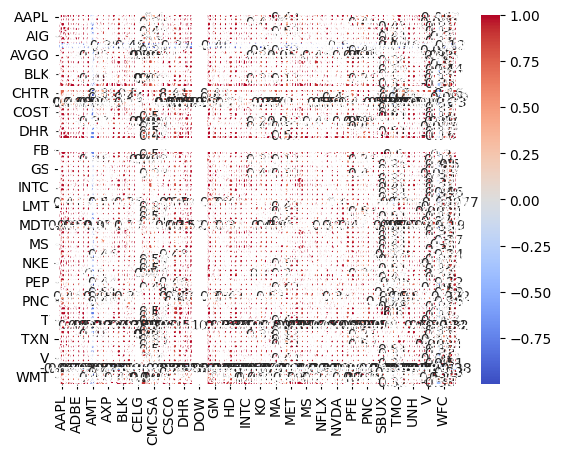

In [3]:
tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'Meta', 'TSLA', 'NVDA', 'JPM', 'V', 'JNJ', 'MA', 'UNH', 'BAC', 'PG', 'HD', 'NFLX', 'XOM', 'PYPL', 'VZ', 'DIS', 'PFE', 'CSCO', 'T', 'KO', 'WMT', 'INTC', 'IBM', 'NKE', 'MRK', 'CVX', 'BA', 'ABT', 'ADBE', 'ORCL', 'CMCSA', 'PEP', 'AMGN', 'PM', 'MDT', 'MMM', 'ACN', 'LMT', 'DHR', 'CVS', 'NEE', 'RTX', 'HON', 'TGT', 'CHTR', 'LOW', 'TXN', 'UNP', 'AXP', 'TMO', 'COST', 'MCD', 'NOC', 'CAT', 'SBUX', 'BLK', 'CME', 'AVGO', 'AIG', 'MS', 'GS', 'CELG', 'AMT', 'UPS', 'PNC', 'BMY', 'WFC', 'DOW', 'DISCA', 'CI', 'VLO', 'FIS', 'MET', 'GM']
#89 items
start_date = datetime.strptime("2019-01-1", "%Y-%m-%d") 
end_date = start_date+ timedelta(days=7) 


data = yf.download(tickers, start=start_date, end=end_date)
dataClose = data["Close"]
dataClose = dataClose.reset_index().drop(columns=['Date'])
returns_pct = dataClose.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])
corr = returns_pct.corr() # calculate the correlations between the returns of each pair of stocks
sns.heatmap(corr,annot=True,cmap="coolwarm")
df = pd.DataFrame(corr)
titles = df.columns.tolist()

Connected Graph Found


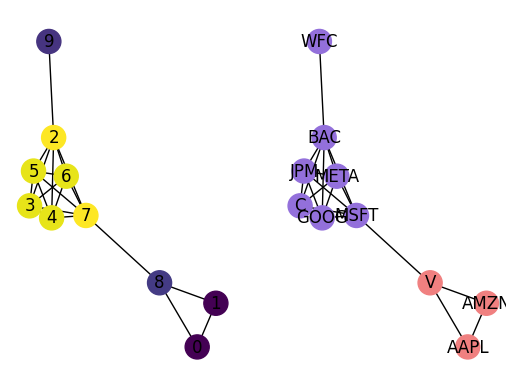

In [110]:
def truncate(f,relaxer=.99): 
    if (abs(f) < relaxer):
        return 0
    else:
        return 1
relaxer=.9999
truncated=corr.applymap(truncate)
# we already know that every stock is perfectly correlated with itself, so the ones on the diagonal are not really useful information. Let's get rid of them.
adj = truncated- np.identity(10)
stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix

while nx.is_connected(stocknet)==False:
    relaxer=relaxer-.0001
    truncated=corr.applymap(truncate)
    adj = corr.applymap(lambda x: truncate(x, relaxer=relaxer))- np.identity(10)
    stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix
else:
    print("Connected Graph Found")
    #print(relaxer)

IndexedStocknet=stocknet
Indexedstock_layout = nx.spring_layout(IndexedStocknet,seed=10)
stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns))) # keep the stock tickers as the names of the nodes (instead of integers)
stock_layout = nx.spring_layout(stocknet,seed=10) # fix our layout
L = nx.laplacian_matrix(stocknet).todense()
(u,v) = np.linalg.eig(L)
u_sorted = np.sort(u)
v_sorted = v[:, u.argsort()]
colors = [ "lightcoral" for i in range(0,10) ]
for i in range(0,10):
    if (v_sorted[i,1] < 0):
        colors[i] = "mediumpurple"


eigen_cent = nx.eigenvector_centrality(IndexedStocknet)
eigen_colors = [eigen_cent[i] for i in range(0,10)]
fig, (ax1, ax2) = plt.subplots(ncols=2)

# Draw the graphs in the subplots
nx.draw(IndexedStocknet,Indexedstock_layout,node_color=eigen_colors,with_labels=True,ax=ax1)
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True,ax=ax2)

plt.show()

In [111]:

df = pd.DataFrame(eigen_cent,index=[0])
dfT= pd.DataFrame(titles)
# print the resulting DataFrame
mat1=df.T
mat2=dfT

joined_mat = pd.concat([mat1, mat2], axis=1)
df=joined_mat
# print the resulting joined matrix
joined_mat.head()
df.columns = ['centrality', 'stock']
df = df.iloc[:, [1, 0]]
df = df.sort_values('centrality',ascending=False)
df=df.reset_index(drop=True)
centralitydf=df

print(centralitydf)
#print(centralitydf['stock'])

  stock  centrality
0  MSFT    0.415146
1   BAC    0.413650
2     C    0.400213
3  GOOG    0.400213
4   JPM    0.400213
5  META    0.400213
6     V    0.090653
7   WFC    0.081574
8  AAPL    0.022270
9  AMZN    0.022270


In [112]:

#print(centralitydf['centrality'])
total = centralitydf['centrality'].sum()
# Calculate the percentage share of each value with respect to the sum of the column
centralitydf['PercentageShare'] = centralitydf['centrality'] / total

# Print the resulting DataFrame
#print(centralitydf)

start_date = start_date+ timedelta(days=6)
end_date = end_date + timedelta(days=7)
#end_date = end_date.strftime("%Y-%m-%d")


data = yf.download(tickers, start=start_date, end=end_date)
dataOpen = data["Open"]
#print(dataOpen.head())
returns_pct = dataOpen.pct_change()
#returns_pct = returns_pct.drop(returns_pct.index[0])

data = returns_pct
df = pd.DataFrame(data)
#print(df)
# choose a row to compute the weighted sum of
row_to_sum = 1

# specify the weights as a list or array (here, we use equally weighted values)
weights = centralitydf['PercentageShare']
weights = weights.values.ravel()

# compute the weighted sum of the row
weighted_sum = (df.iloc[row_to_sum, :] * weights).sum()
#print(df)
#NominalReturns=weighted_sum
# print the weighted sum of the row
print(f"Return is {weighted_sum*100}")


[*********************100%***********************]  10 of 10 completed
Return is 1.3556175305502154
